In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Input
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Functie om maskers voor te verwerken om binaire waarden te garanderen
def preprocess_mask(mask):
    mask = np.where(mask > 0, 1, 0).astype(np.uint8)
    return mask

# Functie om pixels met 1 of 0 te tellen
def count_pixels(mask):
    unique, counts = np.unique(mask, return_counts=True)
    pixel_count = dict(zip(unique, counts))
    return pixel_count

# Functie om afbeeldingen weer te geven
def display_images(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

# Drempel toepassen op voorspelde maskers voor binaire segmentatie
def threshold_predictions(predictions, threshold=0.5):
    return (predictions > threshold).astype(np.uint8)

Total images: 8802
Steps per epoch: 137
Validation steps: 27.0


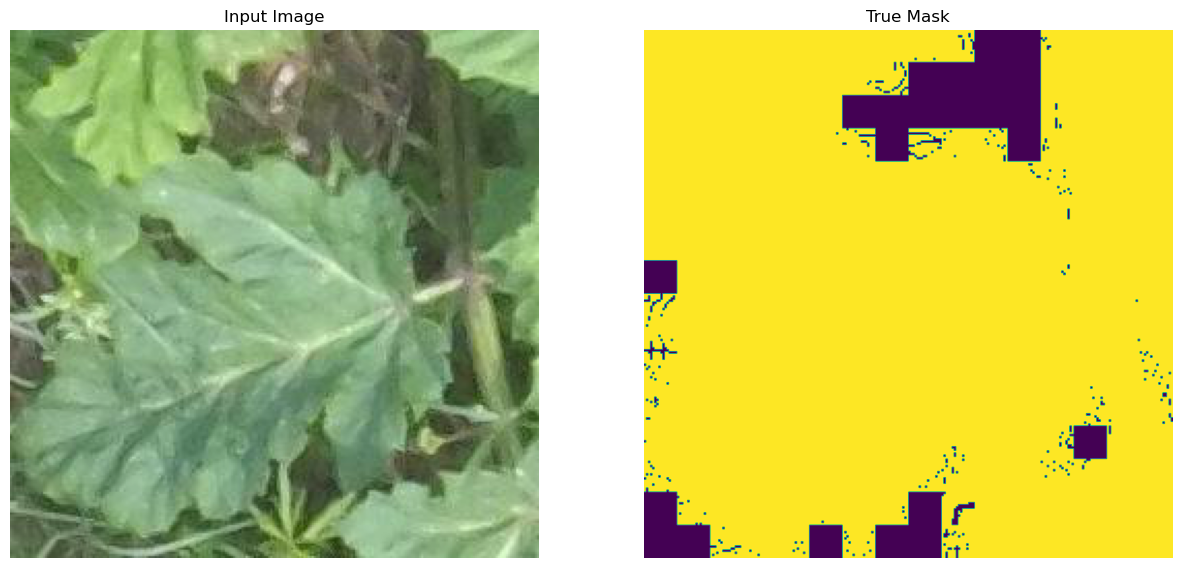

In [3]:
def batch_generator(image_folder, mask_folder, batch_size):
    image_files = os.listdir(image_folder)
    mask_files = os.listdir(mask_folder)
    while True:
        batch_images = []
        batch_masks = []
        for i in range(batch_size):
            img_file = image_files[i % len(image_files)]
            mask_file = mask_files[i % len(mask_files)]
            
            img_path = os.path.join(image_folder, img_file)
            mask_path = os.path.join(mask_folder, mask_file)
            
            image = load_img(img_path, target_size=(256, 256))
            mask = load_img(mask_path, target_size=(256, 256), color_mode="grayscale")
            
            image = img_to_array(image) / 255.0
            mask = img_to_array(mask)
            mask = preprocess_mask(mask)
            
            batch_images.append(image)
            batch_masks.append(mask)
        
        yield np.array(batch_images), np.array(batch_masks)

image_folder = 'zelf gelabelde data/image_patches'
mask_folder = 'zelf gelabelde data/mask_patches'

batch_size = 64
total_images = len(os.listdir(image_folder))
total_masks = len(os.listdir(mask_folder))

# Bereken steps_per_epoch en validation_steps
steps_per_epoch = total_images // batch_size
validation_steps = (total_images * 0.2) // batch_size

print(f"Total images: {total_images}")
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

generator = batch_generator(image_folder, mask_folder, batch_size=batch_size)

batch_images, batch_masks = next(generator)
train_images, test_images, train_masks, test_masks = train_test_split(batch_images, batch_masks, test_size=0.2, random_state=42)

# Voorbeeldweergave van een afbeelding en masker
sample_image, sample_mask = train_images[7], train_masks[7]
display_list = [sample_image, sample_mask]
display_images(display_list)

In [4]:
from tensorflow.keras.layers import concatenate, UpSampling2D

def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    
    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    
    # Decoder
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    
    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    
    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model = unet_model()
model.summary()

2024-05-17 20:21:32.705728: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-05-17 20:21:32.705753: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-05-17 20:21:32.705759: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-05-17 20:21:32.705793: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-17 20:21:32.705809: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [5]:
# Data augmentatie instellen
data_gen_args = dict(rotation_range=20,
                     width_shift_range=0.2,
                     height_shift_range=0.2,
                     shear_range=0.2,
                     zoom_range=0.2,
                     horizontal_flip=True,
                     fill_mode='nearest')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Gebruik dezelfde zaden voor reproductie
seed = 1
image_datagen.fit(train_images, augment=True, seed=seed)
mask_datagen.fit(train_masks, augment=True, seed=seed)

image_generator = image_datagen.flow(train_images, batch_size=batch_size, seed=seed)
mask_generator = mask_datagen.flow(train_masks, batch_size=batch_size, seed=seed)

train_generator = zip(image_generator, mask_generator)

# Model trainen
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=1, validation_data=(test_images, test_masks), validation_steps=validation_steps)

2024-05-17 20:21:35.376580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


137/137 [==============================] - ETA: 0s - loss: 3.2028 - accuracy: 0.8334

2024-05-17 20:37:52.825185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-17 20:37:54.040939: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 1889573593656164356
2024-05-17 20:37:54.040953: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 12886429984813599400
2024-05-17 20:37:54.040967: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 8092917522115597806
2024-05-17 20:37:54.040970: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 18163083277940547657
2024-05-17 20:37:54.040981: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 464981034157286423
2024-05-17 20:37:54.040986: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous r

137/137 [==============================] - 979s 7s/step - loss: 3.2028 - accuracy: 0.8334 - val_loss: 0.2733 - val_accuracy: 0.8933


2024-05-17 20:41:20.380280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 480ms/step


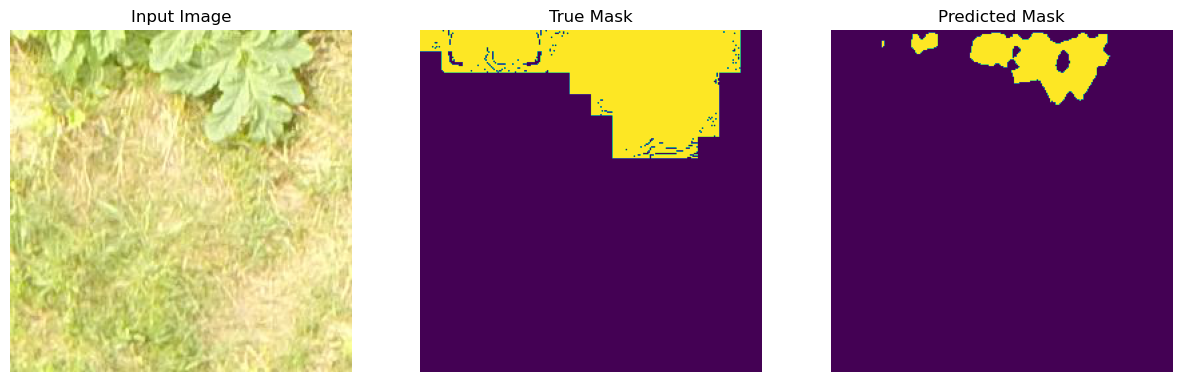

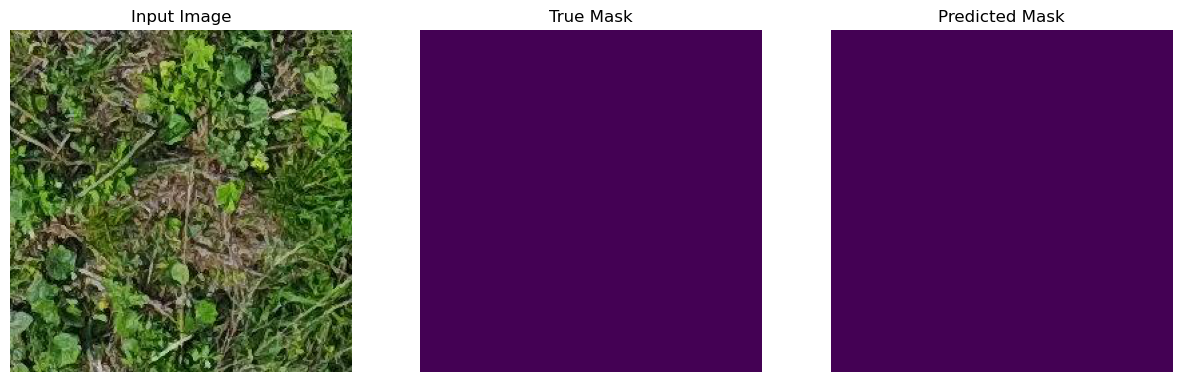

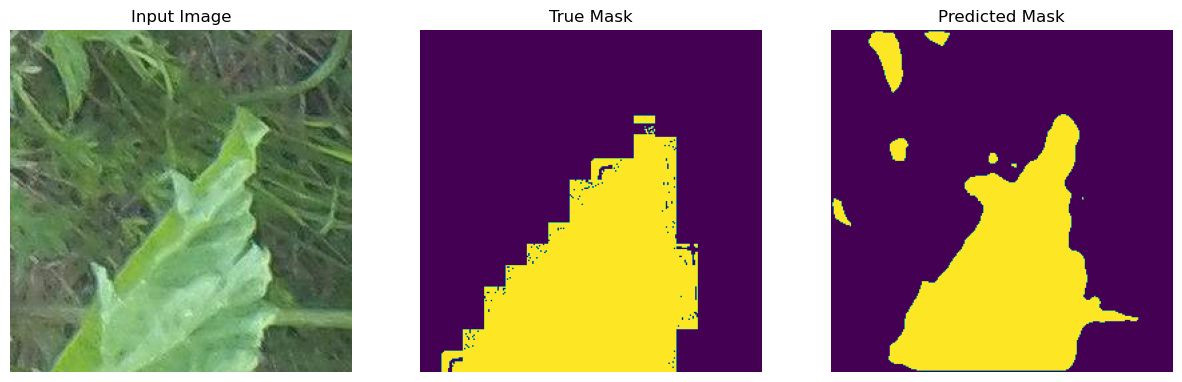

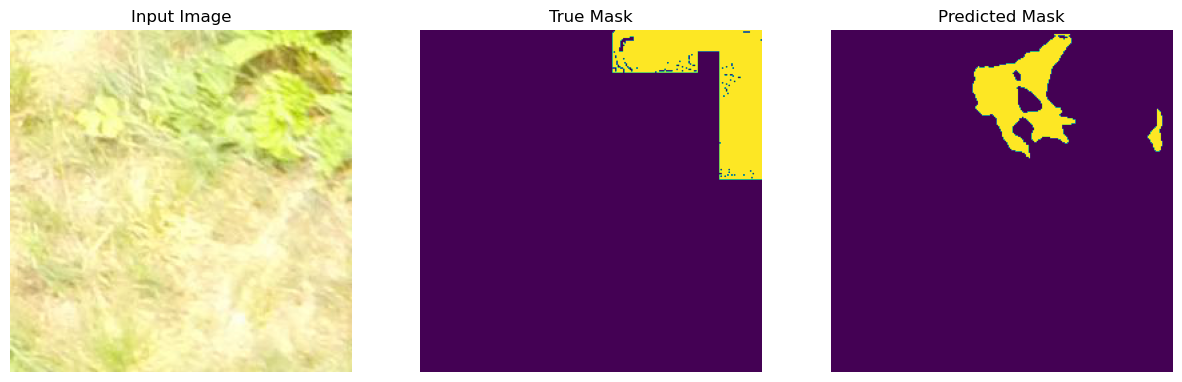

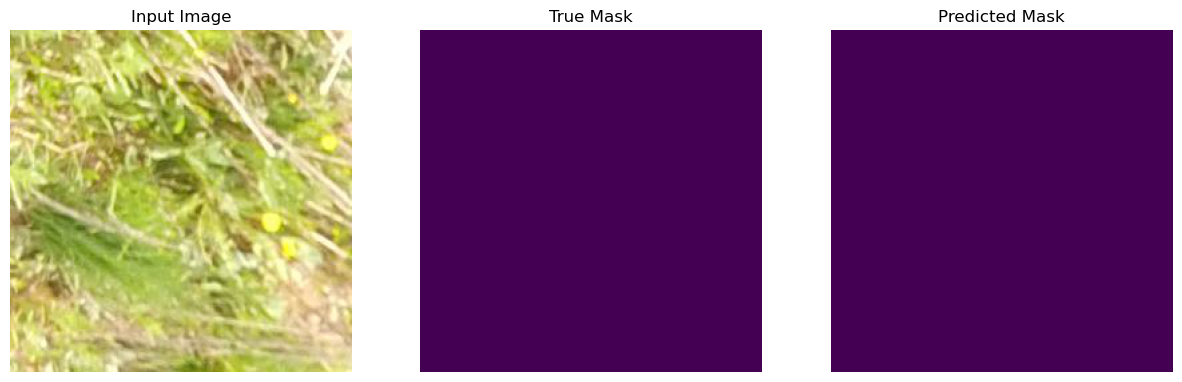

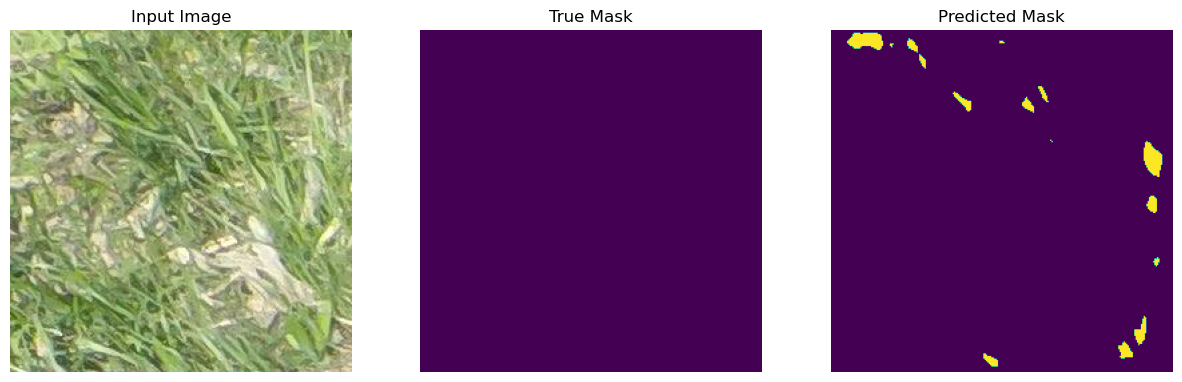

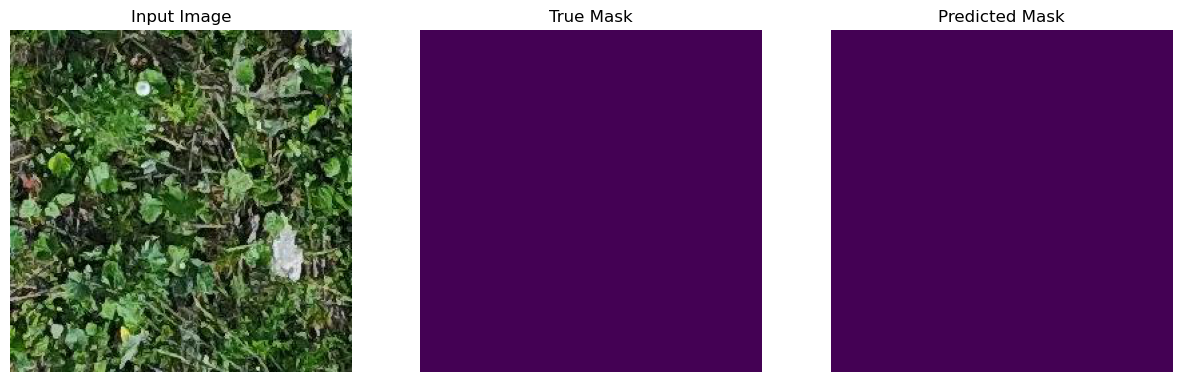

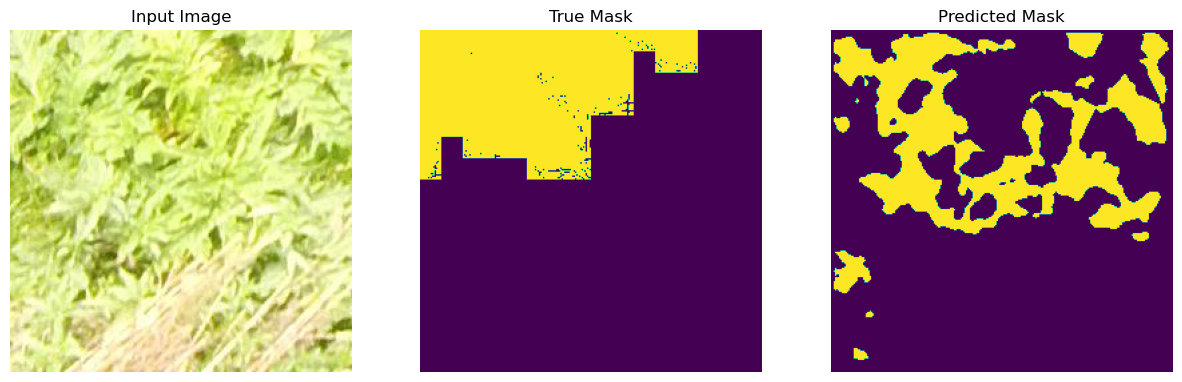

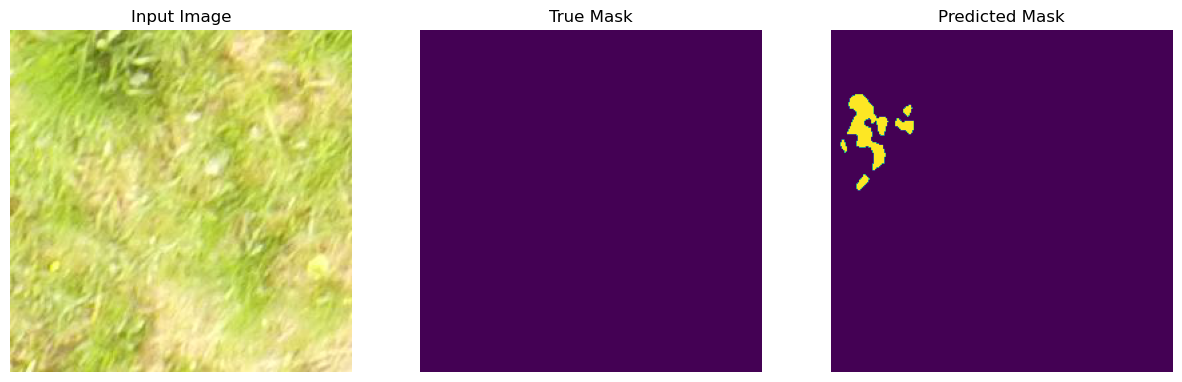

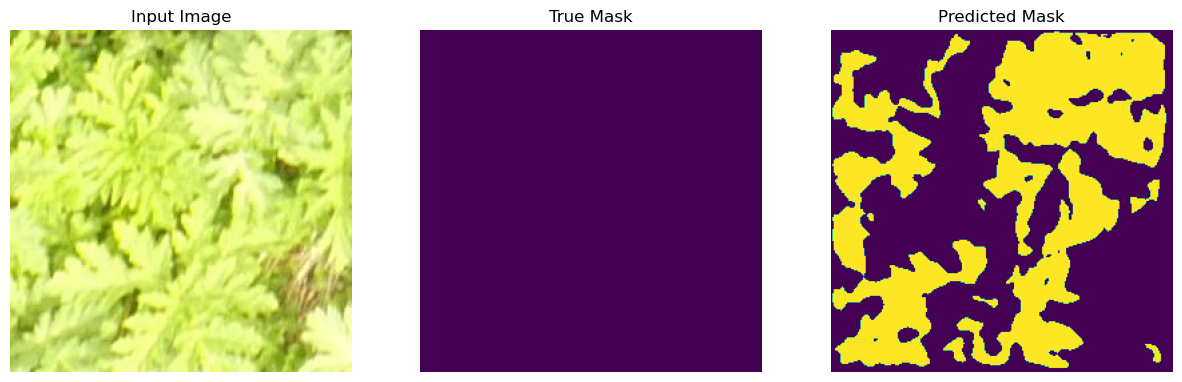

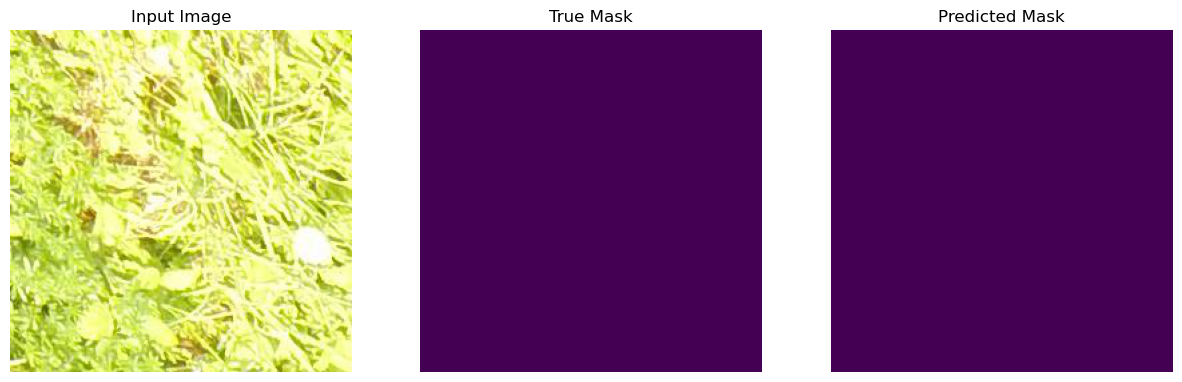

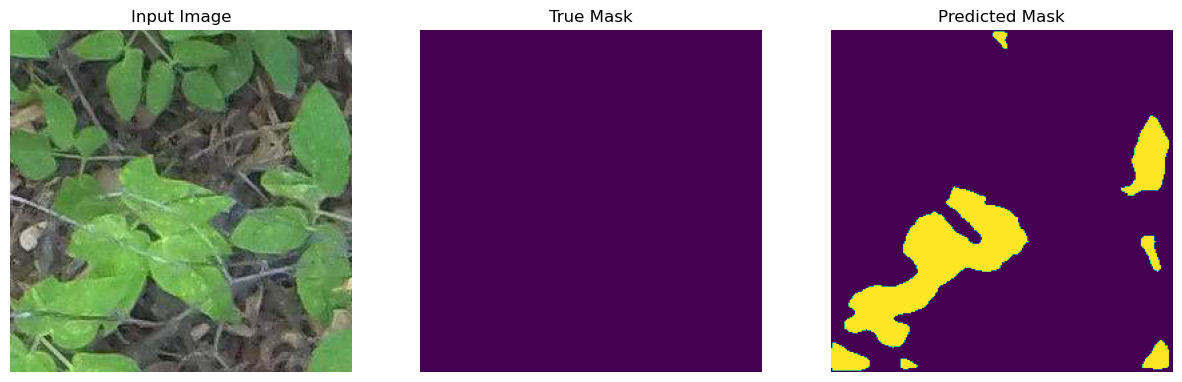

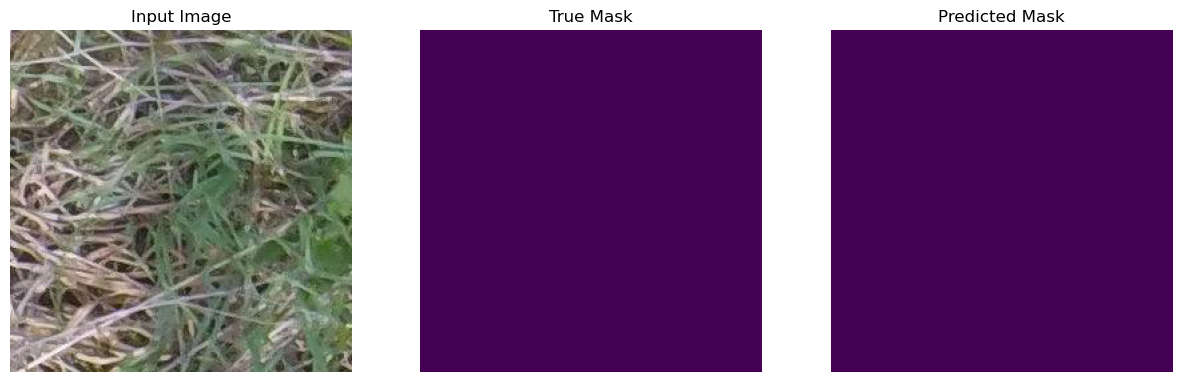

In [6]:
# Voorspellingen weergeven met drempel
pred_masks = model.predict(test_images)
pred_masks_thresholded = threshold_predictions(pred_masks, threshold=0.5)

for i in range(len(test_images)):
    display_images([test_images[i], test_masks[i], pred_masks_thresholded[i]])